# Test Train Split and Cross Validation

## Review of train/test validation methods

We've discussed overfitting, underfitting, and how to validate the "generalizeability" of your models by testing them on unseen data. 

In this lab you'll practice two related validation methods: 
1. **train/test split**
2. **k-fold cross-validation**

Train/test split and k-fold cross-validation both serve two useful purposes:
- We prevent overfitting by not using all the data, and
- We retain some remaining data to evaluate our model.

In the case of cross-validation, the model fitting and evaluation is performed multiple times on different train/test splits of the data.

Ultimately we use can the training and testing validation framework to compare multiple models on the same dataset. This could be comparisons of two linear models or of completely different models on the same data.

## Instructions

For your independent practice, fit **three different models** on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model that you like. 

**Start with train/test split validation:**
* Fix a testing/training split of the data
* Train each of your models on the training data
* Evaluate each of the models on the test data
* Rank the models by how well they score on the testing data set.

**Then try K-Fold cross-validation:**
* Perform a k-fold cross validation and use the cross-validation scores to compare your models. Did this change your rankings?
* Try a few different K-splits of the data for the same models.

If you're interested, try a variety of response variables.  We start with **MEDV** (the `.target` attribute from the dataset load method).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

### 1. Clean up any data problems

Load the Boston housing data.  Fix any problems, if applicable.

In [3]:
# print(boston.DESCR)

In [4]:
X.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [5]:
# looks good to me! ^_^

### 2. Select 3-4 variables with your dataset to perform a 50/50 test train split on

- Train your model on the the **training** data
- Score and plot your predictions for the **test** data (i.e., a scatter plot of actual y values versus predicted y values)
- How well did your model do?

In [6]:
# convert y to df & join to X df, find abs of correlation plot
c = pd.concat([X, pd.DataFrame(data=y).rename(columns={0: 'MEDV'})], axis=1).corr().abs()

In [7]:
s = c.unstack()
so = s.sort_values(ascending=False)
topVars = pd.DataFrame(so.loc[so < 1].head(7))
topVars.rename(columns={0: 'correllation coefficient'})

,,correllation coefficient
RAD,TAX,0.910228
TAX,RAD,0.910228
NOX,DIS,0.769230
DIS,NOX,0.769230
INDUS,NOX,0.763651
NOX,INDUS,0.763651
AGE,DIS,0.747881


In [8]:
# make a list of the top correllated vars
topLabels = []
for row in topVars.index:
    for item in row:
        if item in ['latitude', 'longitude']:
            continue
        if item in topLabels:
            continue
        else:
            topLabels.append(item)

print(topLabels)

['RAD', 'TAX', 'NOX', 'DIS', 'INDUS', 'AGE']


In [9]:
topLabels[:4]

['RAD', 'TAX', 'NOX', 'DIS']

In [10]:
pd.concat([X, pd.DataFrame(data=y).rename(columns={0: 'MEDV'})], axis=1).corr().abs().loc['MEDV'].sort_values(ascending=False)[1:5]

LSTAT      0.737663
RM         0.695360
PTRATIO    0.507787
INDUS      0.483725
Name: MEDV, dtype: float64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)
# TODO: clean up the print a bit
# X test and train are both 253 rows, 13 cols
# y test and train are both 253 rows, 1 col
print('X_train shape: {}, \
    X_test shape: {}, \
    y_train shape: {}, \
    y_test shape: {}'.format(X_train.shape, X_test.shape, y_train.shape, y_test.shape) )

X_train shape: (253, 13),     X_test shape: (253, 13),     y_train shape: (253,),     y_test shape: (253,)


In [12]:
lm = LinearRegression()

Score of 50/50 model: 67.80000000000001%


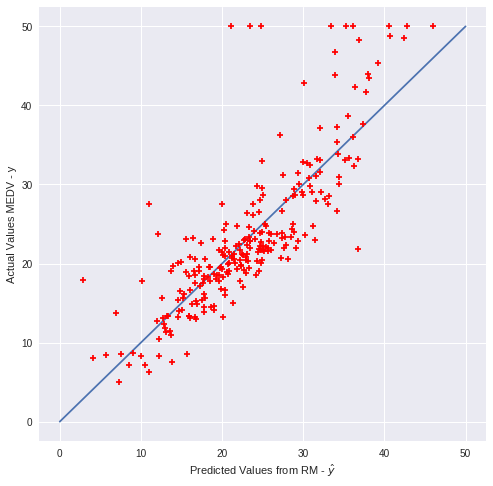

In [13]:
# fit the model, create predictions array and score variable
model_5050 = lm.fit(X_train, y_train)
predictions  =  model_5050.predict(X_test)
score        =  model_5050.score(X_test, y_test)

# Plot the model
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from RM - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")

plt.plot([0, np.max(y_test)], [0, np.max(y_test)])

print('Score of 50/50 model: {}%'.format(round(score,3)*100))
plt.show()

### 3. Try ratios of 70/30 and 90/10 for the training set to test set

- Score and plot your test set (i.e., a scatter plot of actual y values versus predicted y values)
- How does the score change across both of them?

In [14]:
ratioGrid = {'70/30 Model': 0.7, '90/10 Model': 0.9}

for modelName, split in ratioGrid.items():
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split)
    # fit the model, create predictions array and score variable
    model = lm.fit(X_train, y_train)
    predictions  =  model.predict(X_test)
    score        =  model.score(X_test, y_test)
    print('{} has r^2 of: {}'.format(modelName, round(score,3)))

70/30 Model has r^2 of: 0.773
90/10 Model has r^2 of: 0.573


### 4. Try K-Folds cross-validation with _k_ between 5-10 for your regression. 

You can use either `cross_val_score` / `cross_val_predict` or the `KFolds` iterator

- What set of variables are optimal? 
- How do your scores change?  
- How does the variance of the scores change?
- Try different folds to get a sense of how this impacts your score.

In [15]:
# instantiate linear regression object
lr = LinearRegression(normalize=True, n_jobs=-1)

In [16]:
# create test/train split using kfold, note that X is a df and y is a numpy array. 
# We create a grid from 5 to 10 folds and average their respective scores within the folds.
# Modified index mask with .iloc for df, numpy can take index mask directly

# create scores dict to hold scores for a specific fold
scores = {}
# create foldScores dict to hold the scores dictionary
foldScores = {}
# iterate from 5 to 10 folds
foldGrid = range(5, 11)

for j in foldGrid:
    kf = KFold(n_splits=j, shuffle=True, random_state=123)
    
    for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    #     print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # fit the model and aggregate scores
        lr.fit(X_train, y_train)
        scores[i+1] = lr.score(X_test, y_test)
        
    foldScores[j] = scores
    scores = {}

In [17]:
# generate a dictionary with the average values for each of the fold trials from 5 to 10

foldList = []
for fold in foldScores.values():
    scoreList = []
    for score in fold.values():
        scoreList.append(score)
    foldList.append(scoreList)

    
foldAvgs = {}
for i, score in enumerate(foldList):
    foldAvgs[i+foldGrid[0]] = sum(score)/len(score)
    
# print the r^2 scores for each 
foldAvgs

{5: 0.71441350335348242,
 6: 0.71688894521062274,
 7: 0.71564504877394719,
 8: 0.72267804408333791,
 9: 0.72167001816997456,
 10: 0.7067338302712235}

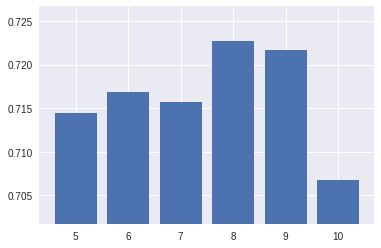

In [18]:
# plot the effect of number of folds on model score

# get min and max avg fold scores for plotting purposes
min = 0.0
max = 0.0

for i, v in enumerate(foldAvgs.values()):
    if i == 0:
        min = v
        max = v
    elif v < min:
        min = v
    elif v > min:
        max = v


plt.bar(range(len(foldAvgs)), foldAvgs.values(), align='center')
plt.xticks(range(len(foldAvgs)), foldAvgs.keys())
axes = plt.gca()
# rescale the y axis plus/minus 0.005 margin
axes.set_ylim([min-0.005,max+0.005])

plt.show()

### 5. [Bonus] optimize the $R^2$ score

Can you optimize your R^2 by selecting the best features and validating the model using train/test split and K-Folds? Set up a scheme to do the following:

1. Create a holdout test set using `train_test_split()`. 
  - We will use the training set in our cross-validation part below to find the right set of columns.
  - We will check the best set of columns that we have found against the holdout test as a final check on our work
2. Iterate through every pair of columns (use a for loop!) in the training set you created in step 1 and look at the average $R^2$ score found by `cross_val_score()`
3. Pick the pair of columns that has the highest cross-validated $R^2$ code and fit a Linear Regression using those columns as the predictors in the full training set you created in step 1.
4. Test this "final" model against the holdout test set you created in step 1. How well does it perform?

### 5.1 Can you explain what could be wrong with this approach?

### 6. [Bonus] Explore another target variable 

Can you find another response variable, given a combination of predictors, that can be predicted accurately through the exploration of different predictors in this dataset?

> *Tip: Check out pairplots, coefficients, and pearson scores.*